# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    # Місце для вашого коду
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name="Layer1")
    # Другий шар, який складається з 256 нейронів
    # Місце для вашого коду
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name="Layer2")
    # Вихідний шар
    # Місце для вашого коду
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes, name="Output")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    # Місце для вашого коду
    x = self.layer_1(x)
    x = self.layer_2(x)

    return self.layer_3(x, activation=tf.nn.softmax) # Місце для вашого коду

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    y_pred_labels = tf.cast(tf.argmax(y_pred, axis=1), tf.float64)

    correct_predict = tf.equal(y_pred_labels, tf.cast(y_true, tf.float64))

    accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float64))

    return accuracy

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    gradients = g.gradient(loss, neural_net.trainable_variables)
    # Обчислимо за ними значення градієнта
    # Місце для вашого коду
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

    # Модифікуємо параметри
    # Місце для вашого коду
    #???

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Місце для вашого коду
        loss_step = cross_entropy(pred, batch_y)
        accuracy_step = accuracy(pred, batch_y)

        loss_history.append(loss_step)
        accuracy_history.append(accuracy_step)

        print(f"Step: {step}, Loss: {loss_step:7.2f}, Accuracy: {accuracy_step:.2%}")


Step: 100, Loss:  286.07, Accuracy: 68.36%
Step: 200, Loss:  153.76, Accuracy: 80.47%
Step: 300, Loss:  212.73, Accuracy: 77.73%
Step: 400, Loss:  167.34, Accuracy: 80.08%
Step: 500, Loss:  146.00, Accuracy: 82.42%
Step: 600, Loss:  145.62, Accuracy: 80.86%
Step: 700, Loss:  108.86, Accuracy: 86.72%
Step: 800, Loss:  139.77, Accuracy: 83.59%
Step: 900, Loss:   90.94, Accuracy: 88.28%
Step: 1000, Loss:  111.41, Accuracy: 88.28%
Step: 1100, Loss:  111.02, Accuracy: 86.33%
Step: 1200, Loss:  110.38, Accuracy: 86.33%
Step: 1300, Loss:   88.22, Accuracy: 90.62%
Step: 1400, Loss:  113.77, Accuracy: 85.16%
Step: 1500, Loss:   79.93, Accuracy: 89.84%
Step: 1600, Loss:   81.01, Accuracy: 89.06%
Step: 1700, Loss:   69.40, Accuracy: 92.97%
Step: 1800, Loss:   85.29, Accuracy: 89.06%
Step: 1900, Loss:   71.02, Accuracy: 92.97%
Step: 2000, Loss:  107.01, Accuracy: 89.06%
Step: 2100, Loss:   64.24, Accuracy: 94.53%
Step: 2200, Loss:   68.23, Accuracy: 91.41%
Step: 2300, Loss:   66.67, Accuracy: 92.9

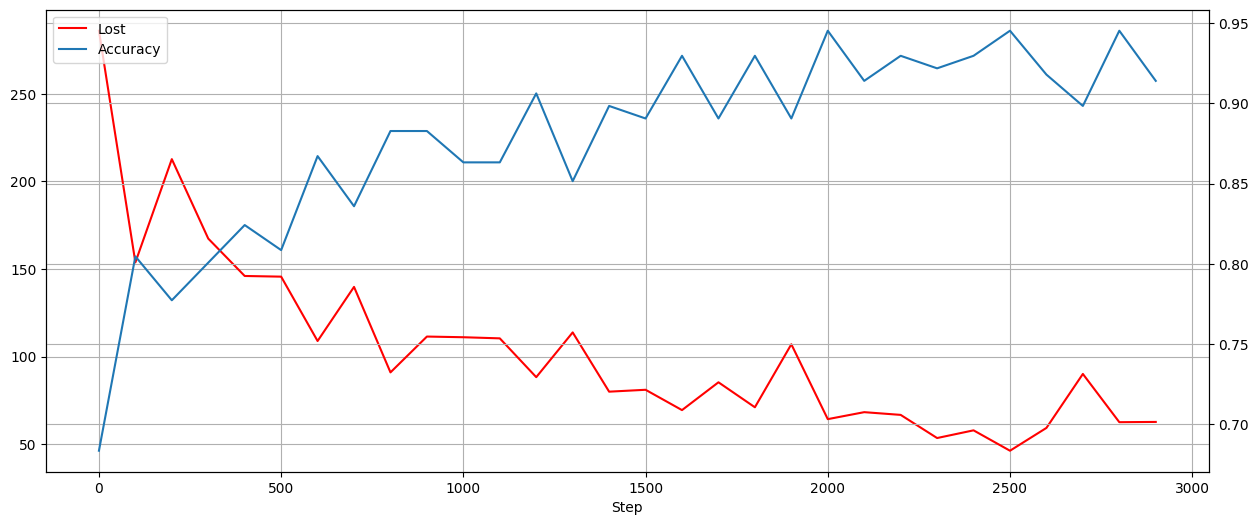

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
# fig = plt.figure(figsize=(15,6))
# plt.plot(range(0, len(accuracy_history)*display_step, 100), loss_history, "r")
# plt.xlabel("Step")
# plt.ylabel("Loss")
# plt.grid()
# plt.show()

# Виведіть графік точності
# Місце для вашого коду
# fig = plt.figure(figsize=(15,6))
# plt.plot(range(0, len(accuracy_history)*display_step, 100), accuracy_history)
# plt.xlabel("Step")
# plt.ylabel("Accuracy")
# plt.grid()
# plt.show()

# Виведіть графік функції втрат , точності
from itertools import chain
legend = []

steps_value = range(0, len(accuracy_history)*display_step, 100)

fig, ax = plt.subplots(figsize=(15,6))

ax.set_xlabel('Step')

plt.plot(steps_value, loss_history, "r", label="Lost", )
legend.append(ax.get_legend_handles_labels())
ax.grid()

ax = ax.twinx() ## add other ax

plt_accuracy = plt.plot(steps_value, accuracy_history, label="Accuracy")
legend.append(ax.get_legend_handles_labels())

lines, labels = list(list(chain.from_iterable(i)) for i in zip(*legend))
ax.legend(lines, labels, loc='best')
ax.grid()

plt.show()

In [9]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
print(f"Accuracy mean = {np.mean(accuracy_history):.2%}")

# Тестування моделі на тестових даних
# Місце для вашого коду
test_pred = neural_net(x_test)
test_pred_values = np.argmax(test_pred, axis=1)
print(f"Accuracy test = {accuracy(test_pred, y_test).numpy():.2%}")

Accuracy mean = 87.81%
Accuracy test = 90.70%


count_select=10, test_selected_accuracy=90.00%


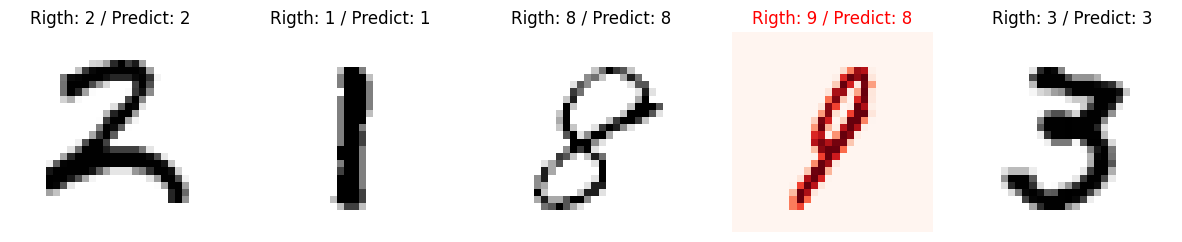

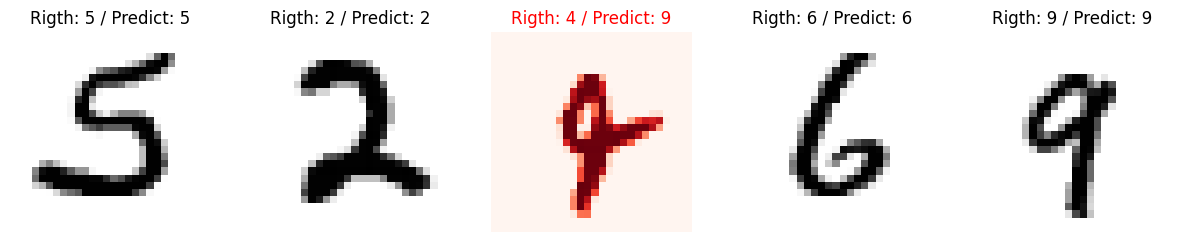

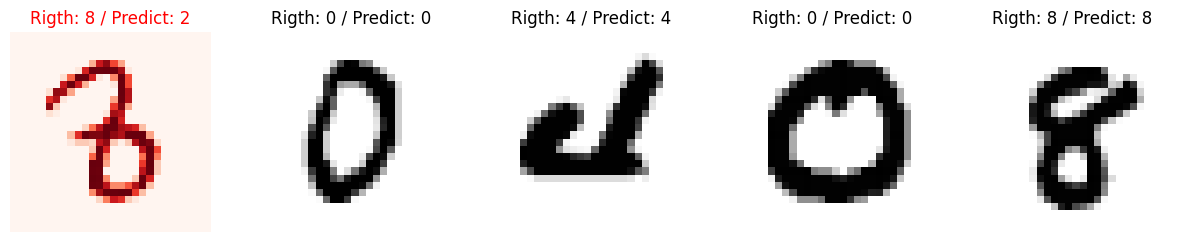

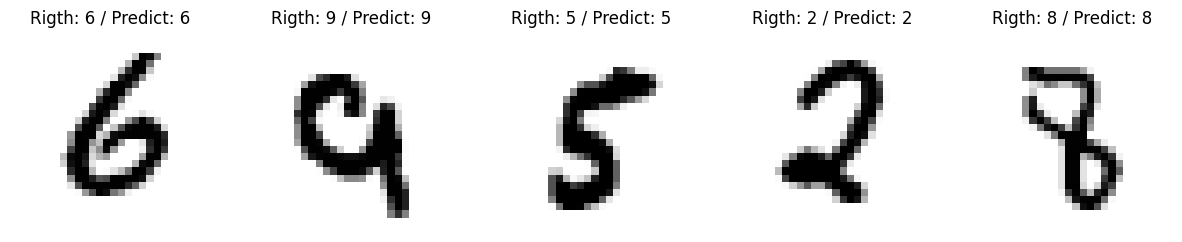

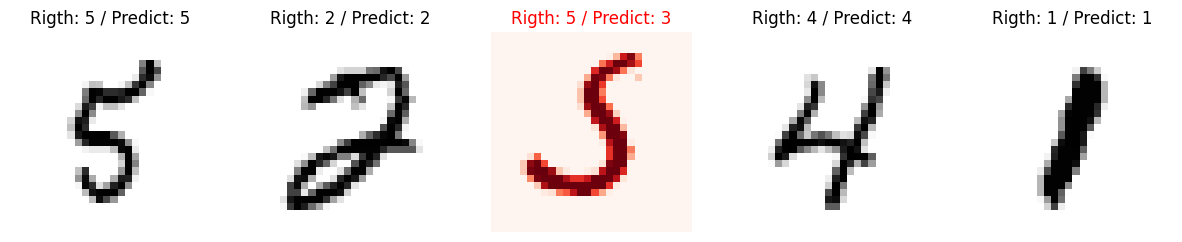

In [14]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.

# Місце для вашого коду
count_select = 10
test_pred_secected = neural_net(x_test[:count_select])
test_selected_accuracy = accuracy(test_pred_secected, y_test[:count_select]).numpy()
print(f"{count_select=}, {test_selected_accuracy=:.2%}")

count_random = 5

for _ in range(5): # повторимо 5 разів
    random_in_test = np.random.randint(0, len(x_test), count_random)
    x_random = x_test[random_in_test]
    y_random = y_test[random_in_test]

    random_predict = neural_net(x_random)

    img_size = int(x_test.shape[1]**(1/2))

    fig = plt.figure(figsize=(15,6))
    for idx, i in enumerate(np.argmax(random_predict, axis=1)):
        value_correct = y_random[idx] == i
        plt.subplot(1, count_random, idx + 1)
        plt.imshow(x_random[idx].reshape(img_size, img_size), cmap = 'gray_r' if value_correct else 'Reds')
        plt.title(f'Rigth: {y_random[idx]} / Predict: {i}', color = 'black' if value_correct else 'r' )
        plt.axis("off")
    plt.show()


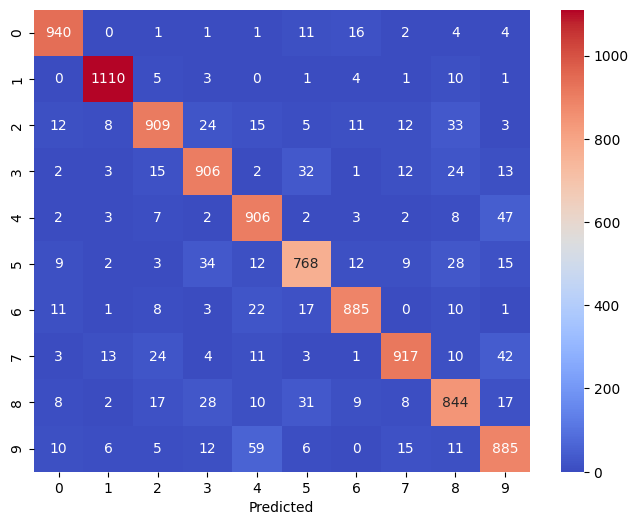

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.97      0.98      0.97      1135
           2       0.91      0.88      0.90      1032
           3       0.89      0.90      0.89      1010
           4       0.87      0.92      0.90       982
           5       0.88      0.86      0.87       892
           6       0.94      0.92      0.93       958
           7       0.94      0.89      0.91      1028
           8       0.86      0.87      0.86       974
           9       0.86      0.88      0.87      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Average error 9.30%


In [11]:
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?
conf_matrix = confusion_matrix(y_test, test_pred_values)

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='g') ## color
plt.xlabel("Predicted")
plt.show()

c_report = classification_report(y_test, test_pred_values, output_dict=True)
print(classification_report(y_test, test_pred_values))
average_error = 1 -c_report['accuracy']
print(f"Average error {average_error:.2%}" )


look train

In [12]:
_ = [print(f"Number {i[0]} in train count - {i[1]}") for i in zip(*np.unique(y_train, return_counts=True))]

Number 0 in train count - 5923
Number 1 in train count - 6742
Number 2 in train count - 5958
Number 3 in train count - 6131
Number 4 in train count - 5842
Number 5 in train count - 5421
Number 6 in train count - 5918
Number 7 in train count - 6265
Number 8 in train count - 5851
Number 9 in train count - 5949


Як ми бачимо що наша функция метрики accuracy, та classification report показує майже однакову середню точність 90 %
Для різних варіюеться від 86 до 98 % (дивимость recall). Як мені знаеться це пов`язано з написанням той чи іньшой цифри (я к ми і бачимо 1 майже пишеться однаково),
та також с кількістю цих прикладів у навчальному датасеті ( мабуть це 5). Також для 5 ми бачимо і у тестової вибірки (892 екземпляра - це меньш ніж усі іньші, а 1 навпаки).

In [13]:
from IPython.display import Markdown as md

md(f"Cередня похибка склала: {average_error:.2%}")

Cередня похибка склала: 9.30%

Також був проведено навчвння з параметром :
learning_rate = 0.002 # швидкість навчання нейронної мережі

Та отримали такі результати :

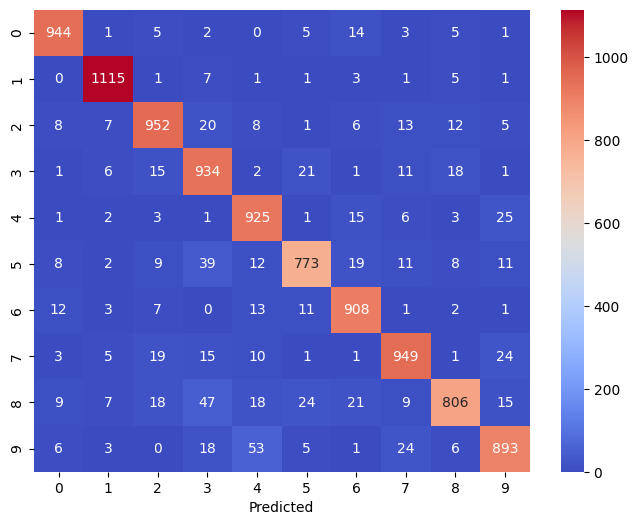


              precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.92      0.92      1032
           3       0.86      0.92      0.89      1010
           4       0.89      0.94      0.91       982
           5       0.92      0.87      0.89       892
           6       0.92      0.95      0.93       958
           7       0.92      0.92      0.92      1028
           8       0.93      0.83      0.88       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.92     10000
    macro avg      0.92      0.92      0.92     10000
    weighted avg   0.92      0.92      0.92     10000

Average error 8.01%

Як бачимо при такому значенні параметру отримали більш точну модель, заеться шо поточну модель можно теж донавчати за рахунок збільшеня кількості training_steps (епох)